# This notebook gives shows the `preload_data` method applied to a zipped zarr file

This notebook shows an example how to preload a Zarr file, whcih is published in compressed tar format on the [https://zenodo.org](https://zenodo.org) webpage. The compressed files will be downloaded, unpacked and the the Zarr files will be made available, which can be subsequently used by the data store as usual. 

### Setup
In order to run this notebook, you need to install [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo), following the [README](../README.md).

Note that [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store
from xcube.core.store import get_data_store_params_schema

CPU times: user 3.01 s, sys: 216 ms, total: 3.22 s
Wall time: 1.3 s


First, we get the store parameters needed to initialize a zenodo [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). 

In [2]:
%%time
store_params = get_data_store_params_schema("zenodo")
store_params

CPU times: user 34.9 ms, sys: 6.97 ms, total: 41.8 ms
Wall time: 41.2 ms


We initiate a zenodo [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework) for the record https://zenodo.org/records/11546130 with the record ID `root="11546130"`. Note that the `xcube-zenodo` plugin is recognized after installation by setting the first argument to `"zenodo"` in the `new_data_store` function. We can optionally specify the cache data store's ID and parameters using the `cache_store_id` and `cache_store_params` keyword arguments. By default, `cache_store_id` is set to `file`, and `cache_store_params` defaults to `dict(root="zenodo_cache/11546130", max_depth=10)`.

In [3]:
%%time
store = new_data_store("zenodo", root="11546130")

CPU times: user 5.1 ms, sys: 11 μs, total: 5.11 ms
Wall time: 5.08 ms


Compressed files can be preloaded using the `preload_data` method. This approach enables the downloading of compressed files that cannot be lazily loaded, allowing them to be stored and readily available for the duration of the project. Also this method uses `preload_params`, which can be viewed in the next cell.

In [4]:
%%time
preload_params = store.get_preload_data_params()
preload_params

CPU times: user 31 μs, sys: 3 μs, total: 34 μs
Wall time: 36 μs


The `preload_data` method returns a store which may be used subsequently to access the preloaded data, as shown in the subsequent cells. If no data IDs are given, all available data in compressed format will be preloaded. Note that the `preload_method` is new and highly experimental. 

In [5]:
cache_store = store.preload_data(
    "EventCube_ranked_pot0.01_ne0.1.zarr.zip",
    "mergedlabels.zarr.zip"
)

The data IDs can be view by listing the data IDs of the cache store, which is returned by the `preload_data` method. The new data ID is identical to the original, except that the `.zip` extension indicating a compressed format has been removed.

In [7]:
cache_store.list_data_ids()

['mergedlabels.zarr', 'EventCube_ranked_pot0.01_ne0.1.zarr']

Next we want to open one of the datasets. We first view the availbale parameters to open the data. 

In [8]:
%%time
open_params = cache_store.get_open_data_params_schema(
    data_id="EventCube_ranked_pot0.01_ne0.1.zarr"
)
open_params

CPU times: user 633 μs, sys: 0 ns, total: 633 μs
Wall time: 637 μs


In [9]:
%%time
ds = cache_store.open_data("EventCube_ranked_pot0.01_ne0.1.zarr")
ds

CPU times: user 9.72 ms, sys: 0 ns, total: 9.72 ms
Wall time: 27.5 ms


<xarray.Dataset> Size: 111GB
Dimensions:    (latitude: 721, longitude: 1440, time: 26663)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-12-31
Data variables:
    layer      (latitude, longitude, time) float32 111GB dask.array<chunksize=(6, 120, 5844), meta=np.ndarray>

We plot the opened data at the last time step as an example below.

CPU times: user 1min 24s, sys: 3.99 s, total: 1min 27s
Wall time: 9.01 s


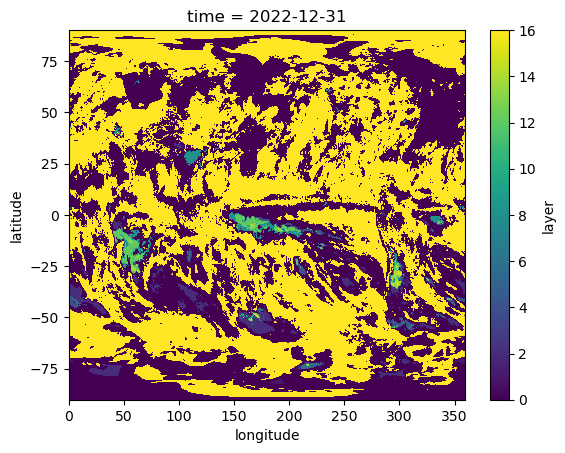

In [10]:
%%time
ds.layer.isel(time=-1).plot()